# Getting started with Bruges

This notebook accompanies [a blog post on agilegeoscience.com](http://www.agilegeoscience.com/blog/). 

You need to install Bruges to run this notebook. You can clone the repository on GitHub or if you have pip installed, in a terminal you can do,

    pip install bruges

This notebook also requires Welly, which you can install like so:

    pip install welly

In [1]:
import bruges as b
b.__version__

'0.2.2'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<hr />

## AVO calculations

### Offset dependent reflectivity

|  | Vp [m/s] | Vs [m/s] | Density [kg/m3] |  
|-------------|----------|----------|----------|
| upper layer | 3300 | 1500 | 2400 |
| lower layer | 3050 | 1400 | 2075 |

In [3]:
# Upper layer rock properties
vp1 = 3300.0
vs1 = 1500.0
rho1 = 2400.0

# Lower layer rock properties
vp2 = 3050.0
vs2 = 1400.0
rho2 = 2075.0

In [4]:
rc_0 = b.reflection.akirichards(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0)
rc_0

-0.11199577706417983

It'll be more conventient to use list unpacking:

In [5]:
rock1 = [vp1, vs1, rho1]
rock2 = [vp2, vs2, rho2]

In [6]:
rc_0 = b.reflection.akirichards(*rock1, *rock2, theta1=0)
rc_0

-0.11199577706417983

In [7]:
rc_30 = b.reflection.akirichards(*rock1, *rock2, theta1=30)
rc_30

-0.096520698009549363

We can also get the individual terms of Shuey's linear approximation:

In [8]:
rc_terms = b.reflection.shuey2(*rock1, *rock2, theta1=30, terms=True)
rc_terms

(-0.11199577706417983, 0.019688936025916742)

The second term is the product of gradient and $sin^2 \theta$. So we can compute the gradient from this:

In [9]:
intercept = rc_terms[0]
gradient = rc_terms[1] / np.sin(np.radians(30))**2
intercept, gradient

(-0.11199577706417983, 0.07875574410366698)

You can equally well pass in a list of angles,

In [10]:
theta_list = [0, 10, 20, 30]
rc_list = b.reflection.akirichards(*rock1, *rock2, theta1=theta_list)
rc_list

array([-0.11199578, -0.10982911, -0.10398651, -0.0965207 ])

Create an array of angles from 0 to 70, incremented by 1,

In [11]:
theta_range = np.arange(0, 70)

In [12]:
rc_range = b.reflection.akirichards(*rock1, *rock2, theta1=theta_range)

Compare the two-term Aki-Richards approximation with the full Zoeprittz equation for a interface between two rocks:

In [13]:
rc_z = b.reflection.zoeppritz_rpp(*rock1, *rock2, theta1=theta_range)

Put all this data on an AVO plot:

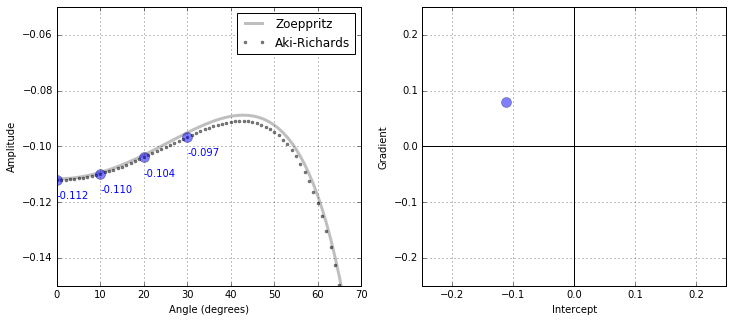

In [14]:
style = {'color': 'blue',
         'fontsize': 10,
         'ha':'left',
         'va':'top',}

fig = plt.figure(figsize=(12,5))

# AVO plot
ax1 = fig.add_subplot(121)
ax1.plot(theta_range, rc_z, 'k', lw=3, alpha=0.25, label='Zoeppritz')
ax1.plot(theta_range, rc_range, 'k.', lw=3, alpha=0.5, label='Aki-Richards')

# We'll also add the four angles...
ax1.plot(theta_list, rc_list, 'bo', ms=10, alpha = 0.5)

# Putting some annotations on the plot.
for theta, rc in zip(theta_list, rc_list):
    ax1.text(theta, rc-0.004, '{:.3f}'.format(rc), **style)

ax1.legend()
ax1.set_ylim((-0.15, -0.05))
ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Amplitude')
ax1.grid()

# Intercept-Gradient crossplot.
ax2 = fig.add_subplot(122)
ax2.plot(intercept, gradient, 'bo', ms=10, alpha = 0.5)

# Put spines for x and y axis.
ax2.axvline(0, color='k')
ax2.axhline(0, color='k')

# Set square axes limits.
mx = 0.25
ax2.set_xlim((-mx, mx))
ax2.set_ylim((-mx, mx))

# Label the axes and add gridlines.
ax2.set_xlabel('Intercept')
ax2.set_ylabel('Gradient')
ax2.grid()

plt.show()

<hr />

## Elastic moduli calculations

Say I want to compute the Lamé parameters &#955; and &#181;, from V<sub>P</sub>, V<sub>S</sub>, and Density. As long as my inputs are in SI units, I can insert these values directly:

|  | Vp [m/s] | Vs [m/s] | Density [kg/m3] |
|-------------|----------|----------|----------|
| upper layer | 3300 | 1500 | 2400 |
| lower layer | 3050 | 1400 | 2075 |

In [15]:
# Upper layer only
b.rockphysics.lam(*rock1), b.rockphysics.mu(*rock1)

(15336000000.0, 5400000000.0)

We can print all the values in terms of GPa ($\times 10^9$ Pa)

In [16]:
print('Upper layer')
print('lambda [GPa]: {:.2f}'.format(b.rockphysics.lam(*rock1) / 1e9))
print('    mu [GPa]: {:.2f}'.format(b.rockphysics.mu(*rock1) / 1e9))
print('\nLower layer')
print('lambda [GPa]: {:.2f}'.format(b.rockphysics.lam(*rock2) / 1e9))
print('    mu [GPa]: {:.2f}'.format(b.rockphysics.mu(*rock2) / 1e9))

Upper layer
lambda [GPa]: 15.34
    mu [GPa]: 5.40

Lower layer
lambda [GPa]: 11.17
    mu [GPa]: 4.07


<hr />

## Rock property analysis and crossplotting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import bruges as b
%matplotlib inline

import welly
welly.__version__

'0.3.1'

In [2]:
w = welly.Well.from_las('../data/L-30.las')

In [3]:
p = welly.Project([w])
from IPython.display import HTML
HTML(p.curve_table_html())

Convert everything to SI units:

In [4]:
dt = w.data['DT']
rhob = w.data['RHOB']
z = dt.basis * 0.3048

vp =  1e6 / (3.28084 * dt)
vp.units = 'm/s'
vs = (vp - 1360) / 1.16  # Castanga model
rhob *= 1000
rhob.units = 'kg/m3'

In [5]:
lm = b.rockphysics.lam(vp, vs, rhob)
mu = b.rockphysics.mu(vp, vs, rhob)

Create a crossplot:

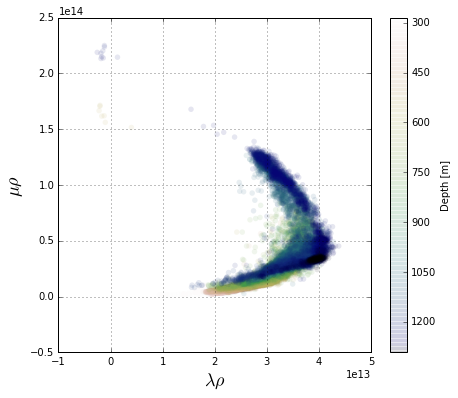

In [6]:
plt.figure(figsize=(7,6))

plt.scatter(lm*rhob, mu*rhob,
            s=30,  # marker size
            color=z, cmap="gist_earth_r",
            edgecolor='none',
            alpha = 0.1)

# Give the plot a colorbar.
cb = plt.colorbar()
cb.ax.invert_yaxis()
cb.set_label("Depth [m]")

# Give the plot some annotation.
plt.xlabel(r'$\lambda \rho$', size=18)
plt.ylabel(r'$\mu \rho$', size=18)
plt.grid()

<hr />

## Backus averaging

In [7]:
lb = 60       # Backus averaging length in metres.
dz = 0.1524   # Sample interval of the log in metres.

In [8]:
lam = b.rockphysics.lam(vp, vs, rhob)
mu = b.rockphysics.mu(vp, vs, rhob)

In [9]:
a = rhob * np.power(vp, 2.0)

a

Curve([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [10]:
x = mu*(lam+mu)/a

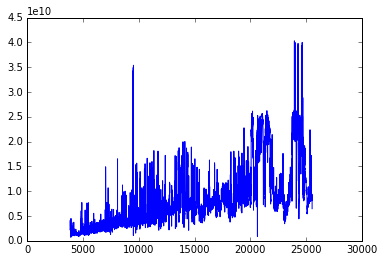

In [11]:
plt.plot(x)

In [12]:
from bruges.util import moving_average

x = 4 * moving_average(mu*(lam+mu)/a, lb/dz, mode='same')

In [13]:
np.nanmean(x)

27304977963.64922

In [14]:
moving_average(mu*(lam+mu)/a, lb/dz, mode='same')

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         2.44204746e+09,   2.41957542e+09,   2.39718318e+09])

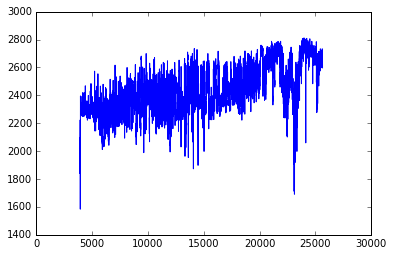

In [15]:
plt.plot(np.pad(rhob, 20, mode='edge'))

In [16]:
vp0, vs0 = b.rockphysics.backus(vp, vs, rhob, lb, dz)

IndexError: arrays used as indices must be of integer (or boolean) type

In [17]:
A, C, F, L, M  = b.rockphysics.backus_parameters(vp, vs, rhob, lb, dz)

8067734304.205273
8067734304.21
6826244490.91
0.4218590788239856
0.421859078824
0.356991824721
3.51670500257529e-11
3.51670500258e-11
2.9762930325e-11
3.51670500257529e-11
3.51670500258e-11
2.9762930325e-11
0.4218590788239856
0.421859078824
0.356991824721
3.51670500257529e-11
3.51670500258e-11
2.9762930325e-11
1.568755182561824e-10
1.56875518256e-10
1.3278638988e-10
12424891296.115108
12424891296.1
10513284725.3


/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/bruges/rockphysics/anisotropy.py:36: RuntimeWarning: invalid value encountered in true_divide
  / moving_average(1.0/a, lb/dz, mode='same')
/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/bruges/rockphysics/anisotropy.py:37: RuntimeWarning: divide by zero encountered in true_divide
  C = 1.0 / moving_average(1.0/a, lb/dz, mode='same')
/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/bruges/rockphysics/anisotropy.py:39: RuntimeWarning: invalid value encountered in true_divide
  / moving_average(1.0/a, lb/dz, mode='same')
/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/bruges/rockphysics/anisotropy.py:40: RuntimeWarning: divide by zero encountered in true_divide
  L = 1.0 / moving_average(1.0/mu, lb/dz, mode='same')


In [24]:
F

array([             nan,              nan,              nan, ...,
         1.49016933e+10,   1.48995000e+10,   1.48966669e+10])

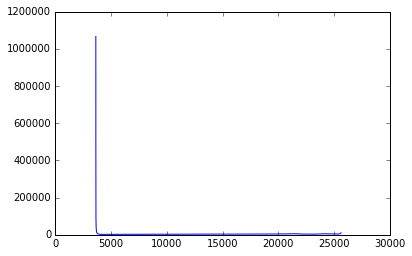

In [19]:
plt.plot(vp0)

In [21]:
vp0

array([            inf,             inf,             inf, ...,
        10586.56205162,  10663.04797201,  10740.90873457])

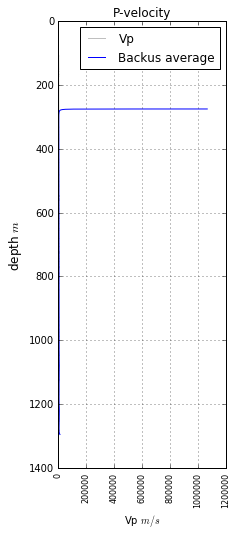

In [20]:
fs = 8  # control the fontsize

fig = plt.figure(figsize=(3,8))

ax1 = plt.subplot(111)
ax1.plot(vp, z, 'k', alpha=0.25, label='Vp')
ax1.plot(vp0, z, 'b', label='Backus average')

# Do some plot annotations
ax1.set_title('P-velocity')
ax1.set_ylabel(r'depth $m$', size=12)
ax1.invert_yaxis()
#ax1.set_xlim((4000,6200))
ax1.set_xlabel(r'Vp $m/s$')
ax1.grid()
ax1.legend()
labels = ax1.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

plt.show()

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:right;" width="40px" /><p style="color:gray; float:right;">© 2015 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;</p>